# Image objects segmented with APOC

We will use the machine learning algorithm [apoc](https://github.com/haesleinhuepf/apoc) to identify microtubule crossings and then we'll image each identified crossing using our mock_scope

## Segmentation with APOC

This section of the notebook was adapted from [Robert Haases APOC notebook](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20a_pixel_classification/apoc_object_segmenter.html) at the [Bio-image Analysis Notebooks](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/intro.html).


APOC is based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [scikit-learn](https://scikit-learn.org/stable/). For object segmentation, it uses a pixel classifier and connected components labeling.

Let's start with loading an example image and some ground truth:

In [1]:
from skimage.io import imsave
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imread
import numpy as np
import apoc
from microscope_gym.mock_scope import microscope_factory
import stackview


cl.OCLArray([[12857., 12095., 12748., ..., 10954., 12440., 12282.],
       [10402., 12988., 11687., ..., 12728., 14038., 12839.],
       [12199., 12239., 11810., ..., 13232., 12005., 11433.],
       ...,
       [14868., 13607., 12815., ..., 12374., 11965., 11034.],
       [11650., 13004., 13011., ..., 10943., 11881., 10532.],
       [14918., 12612., 13623., ..., 10996., 11870., 12409.]],
      dtype=float32)
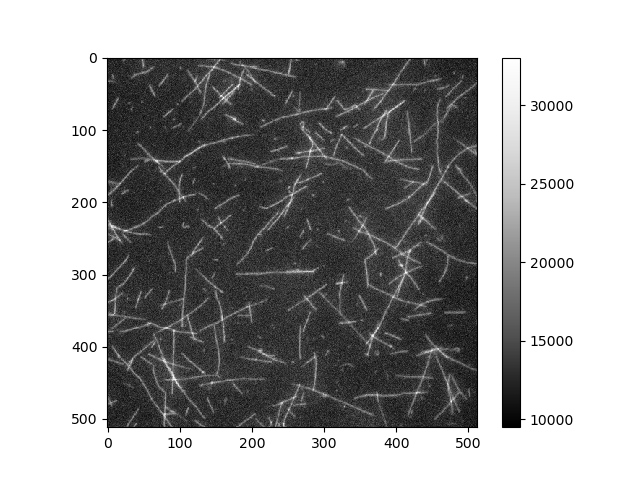
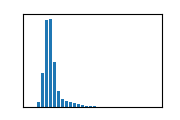

In [2]:
image = imread('data/microtubules.tif')[4]
image

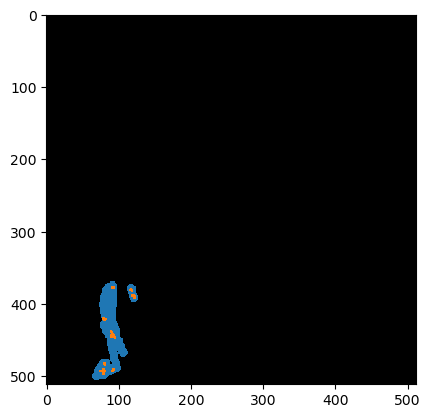

In [3]:
manual_annotations = imread('data/microtubules_manual_annotations.tif')

cle.imshow(manual_annotations, labels=True)

### Training
We now train a ObjectSegmenter, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [4]:
# define features
features = apoc.PredefinedFeatureSet.object_size_1_to_5_px.value

# this is where the model will be saved
cl_filename = 'data/microtubules_object_segmenter.cl'

apoc.erase_classifier(cl_filename)
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, image)

### Prediction / segmentation
The classifier can then be used to classify all pixels in the given image. Starting point is again, the feature stack. Thus, the user must make sure that the same features are used for training and for prediction. Prediction can be done on the CPU using the original scikit-learn code and on the GPU using the generated OpenCL-code. OCLRFC works well if both result images look identical.

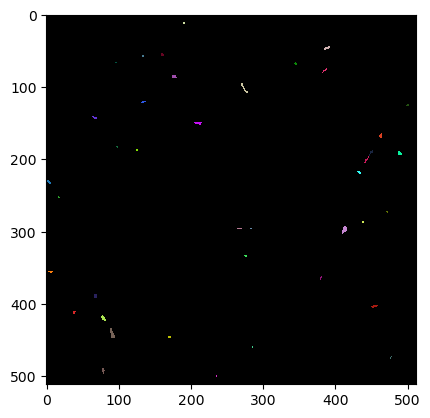

In [5]:
segmentation_result = clf.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

### Postprocessing

First we merge touching labels, then we apply a morphological opening to clean up the labels (keep only labels that are wider than one pixel)

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
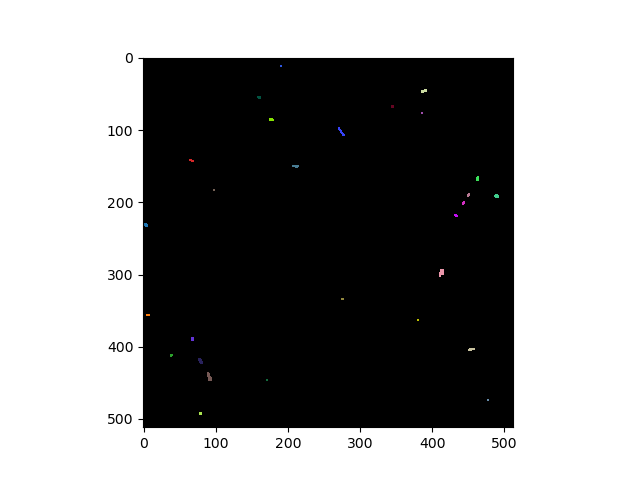

In [6]:

merged_segmentation = cle.merge_touching_labels(segmentation_result)
segmentation_clean = cle.opening_labels(merged_segmentation, None, 1.0)
segmentation_clean


Finally, we get the centroid positions which we want to image

In [7]:
centroids = cle.centroids_of_labels(segmentation_clean)
for i, y_coord in enumerate(np.asarray(centroids[0])):
    x_coord = centroids[1][i]
    print(f'Centroid of object {i} is at ({x_coord}, {y_coord})')

Centroid of object 0 is at (231.9600067138672, 3.5999999046325684)
Centroid of object 1 is at (356.0, 6.0)
Centroid of object 2 is at (412.5, 38.5)
Centroid of object 3 is at (142.5, 66.5)
Centroid of object 4 is at (389.59259033203125, 68.03704071044922)
Centroid of object 5 is at (420.4634094238281, 79.04878234863281)
Centroid of object 6 is at (492.5, 79.0)
Centroid of object 7 is at (442.6349182128906, 91.63491821289062)
Centroid of object 8 is at (183.0, 98.0)
Centroid of object 9 is at (55.421051025390625, 160.1052703857422)
Centroid of object 10 is at (447.0, 171.0)
Centroid of object 11 is at (86.03704071044922, 177.40740966796875)
Centroid of object 12 is at (12.0, 191.0)
Centroid of object 13 is at (150.23529052734375, 210.73529052734375)
Centroid of object 14 is at (102.67391204833984, 273.7608642578125)
Centroid of object 15 is at (334.0, 275.5)
Centroid of object 16 is at (68.0, 344.5)
Centroid of object 17 is at (364.0, 380.0)
Centroid of object 18 is at (77.0, 386.0)
Cen

## Imaging z stacks of each segmented microtubule crossing

### Set up a mock_scope

In [8]:
mock_scope = microscope_factory(overview_image=imread("data/microtubules.tif"),
                                camera_height_pixels=64, camera_width_pixels=64)
print('overview_image shape: ', mock_scope.camera.overview_image.shape)
print('camera height: ', mock_scope.camera.height_pixels)
print('camera width: ', mock_scope.camera.width_pixels)
print('stage position: ', mock_scope.get_stage_position())


overview_image shape:  (11, 512, 512)
camera height:  64
camera width:  64
stage position:  (223.5, 223.5, 5.0)


### Image a z_stack at each centroid position

Some of the labels are too close to the edge, so we need to take care of the Value errors caused by moving the stage outside the safe range.

In [9]:
z_range = np.arange(2, 8)
images = []
for i, y in enumerate(np.asarray(centroids[0])):
    x = centroids[1, i]
    try:
        mock_scope.move_stage_to(x, y)
        images.append(mock_scope.acquire_z_stack(z_range, 1))
    except ValueError: # thrown if the stage position is out of the safe range
        continue
stackview.slice(images[0], continuous_update=True, zoom_factor=5)


## Scanning for 10 events

Let's assume we don't have an overview image. Instead, well scan the entire sample until we found 10 microtubule crossings.

In [10]:
# move to the top right corner of the sample
mock_scope.move_stage_to(0, 0, 0)

z_range = np.arange(10)

# scan the sample
images = []
while len(images) < 10:
    # capture image
    image = mock_scope.acquire_image()

    # apply the classifier
    segmentation_result = clf.predict(features=features, image=image)
    merged_segmentation = cle.merge_touching_labels(segmentation_result)
    segmentation_clean = cle.opening_labels(merged_segmentation, None, 1.0)
    centroids = cle.centroids_of_labels(segmentation_clean)

    if len(centroids[0]) > 0:
        # save the image
        images.append(mock_scope.acquire_z_stack(z_range, 1))
    try:
        # move the stage to the next position
        mock_scope.move_stage_by(relative_x_position=mock_scope.camera.width_pixels)
    except ValueError: # thrown if the stage position is out of the safe range
        try:
            mock_scope.move_stage_to(absolute_x_position=0)
            mock_scope.move_stage_by(relative_y_position=mock_scope.camera.height_pixels)
            continue
        except ValueError: # thrown if the stage position is out of the safe range
            break




we got 10 image stacks of crossing microtubules:

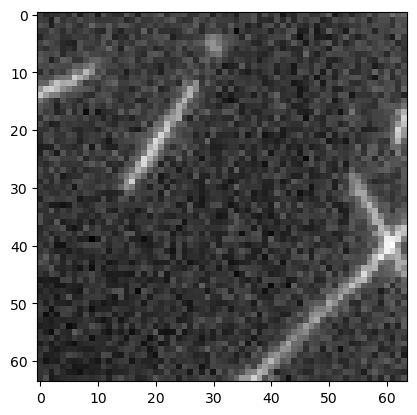

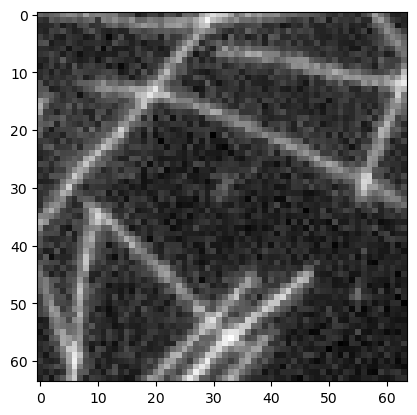

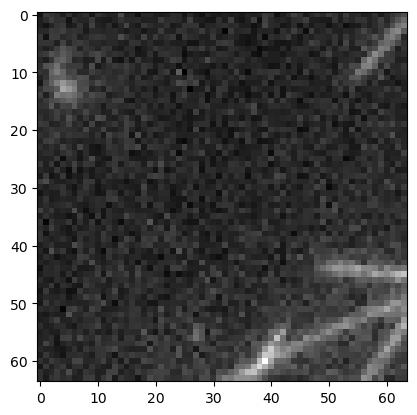

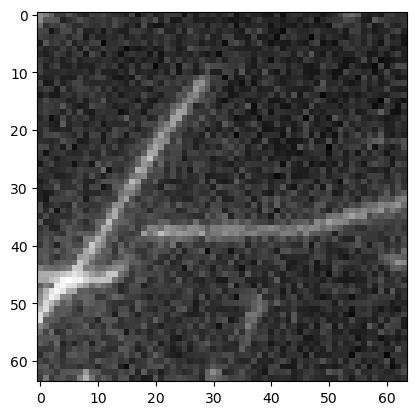

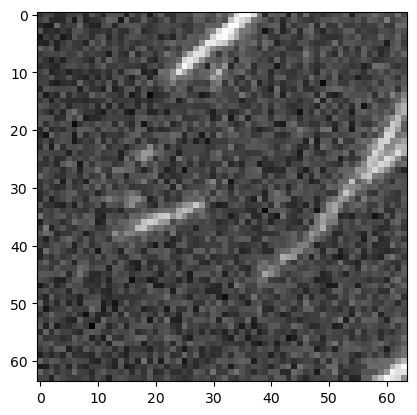

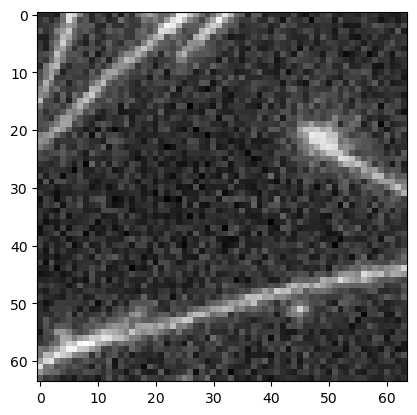

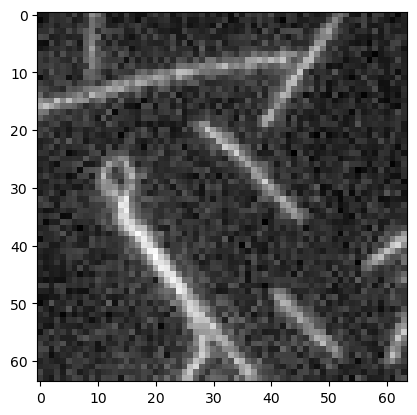

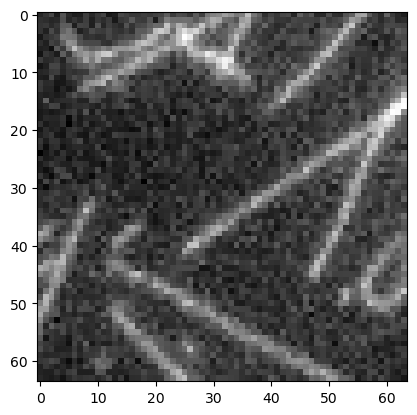

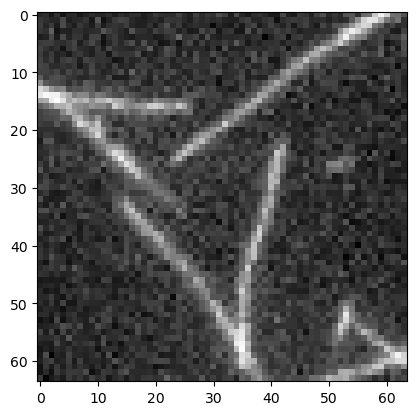

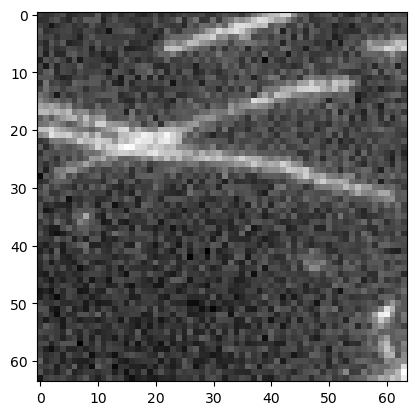

In [11]:
for image in images:
    cle.imshow(image)

And we only needed to scan half the sample to find them:

In [12]:
mock_scope.get_stage_position()

(256, 128, 0)